In [2]:
#Name:Labiba Zahin
#ID:22101114
#SEC:01
#COURSE CODE: CSE425
#SESSION:Summer 2025

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.distributions as dist
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from scipy.linalg import sqrtm
from scipy.stats import entropy


In [ ]:
torch.manual_seed(42)
np.random.seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [ ]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_size = 55000
val_size = 5000
test_size = 5000
train_indices = list(range(train_size))
val_indices = list(range(train_size, train_size + val_size))
test_indices = list(range(test_size))

100%|██████████| 9.91M/9.91M [00:00<00:00, 58.2MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.68MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 12.7MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.80MB/s]


In [ ]:
train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
val_sampler = torch.utils.data.SubsetRandomSampler(val_indices)
test_sampler = torch.utils.data.SubsetRandomSampler(test_indices)

batch_size = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=val_sampler)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, sampler=test_sampler)


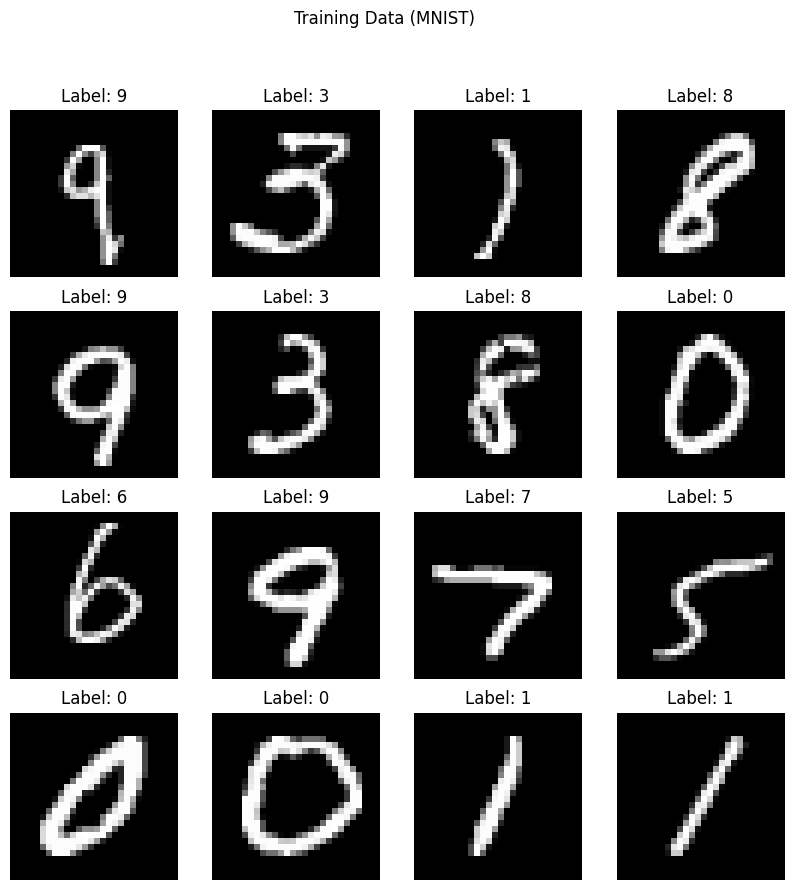

Generating and plotting raw data...


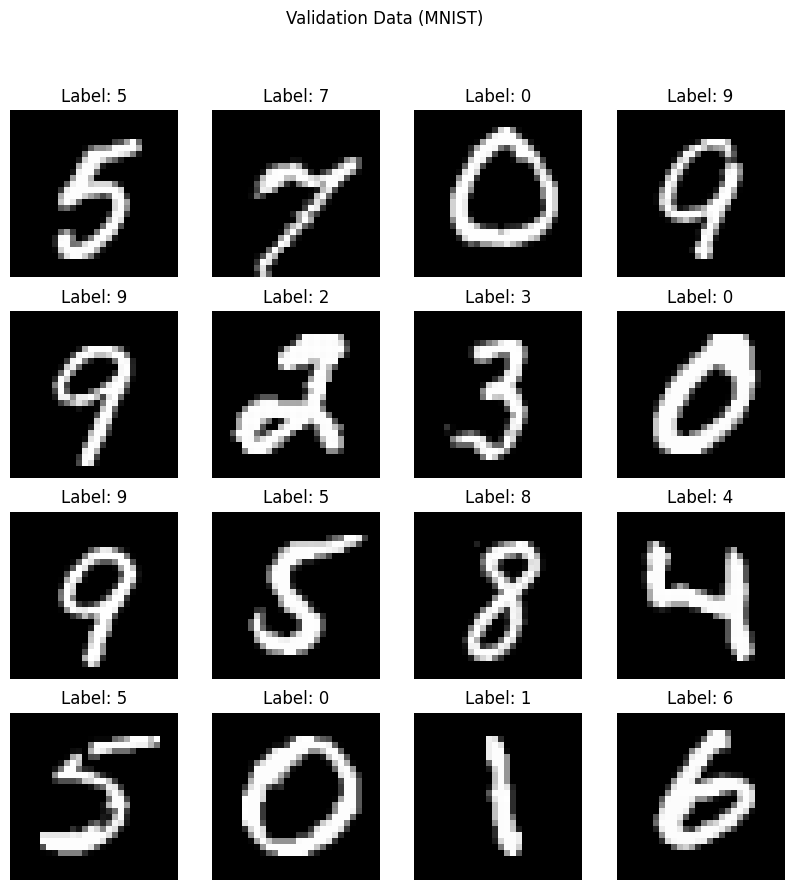

Generating and plotting raw data...


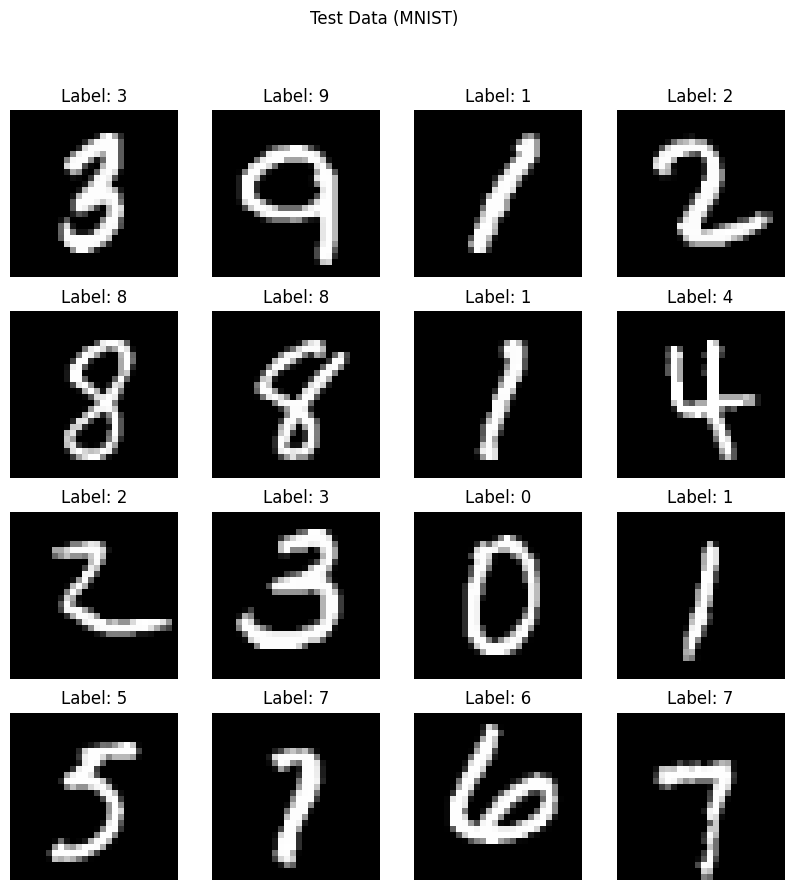

Generating and plotting raw data...


In [ ]:
def plot_raw_data(loader, title, filename):
    data_iter = iter(loader)
    data, labels = next(data_iter)
    plt.figure(figsize=(10, 10))
    for i in range(min(16, len(data))):
        plt.subplot(4, 4, i+1)
        plt.imshow(data[i].numpy().squeeze(), cmap='gray')
        plt.title(f'Label: {labels[i]}')
        plt.axis('off')
    plt.suptitle(title)
    plt.savefig(filename)
    plt.show()
    plt.close()
    print("Generating and plotting raw data...")
plot_raw_data(train_loader, "Training Data (MNIST)", "train_data.png")
plot_raw_data(val_loader, "Validation Data (MNIST)", "val_data.png")
plot_raw_data(test_loader, "Test Data (MNIST)", "test_data.png")


In [ ]:
def flatten_batch(batch):
    return batch.view(batch.size(0), -1)

In [ ]:
class Generator(nn.Module):
    def __init__(self, latent_dim=100, hidden_dim=256, output_dim=784):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.ReLU(),
            nn.Linear(hidden_dim * 2, output_dim),
            nn.Sigmoid()
        )

    def forward(self, z):
        return self.model(z)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=256):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim * 2),
            nn.ReLU(),
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=256, latent_dim=100):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim)
        )

    def forward(self, x):
        return self.model(x)

In [ ]:
class Decoder(nn.Module):
    def __init__(self, latent_dim=100, hidden_dim=256, output_dim=784):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
            nn.Sigmoid()
        )

    def forward(self, z):
        return self.model(z)

In [ ]:

def train_gan(epochs=25, latent_dim=100, lr=0.0001):
    generator = Generator(latent_dim=latent_dim).to(device)
    discriminator = Discriminator().to(device)
    optim_g = optim.Adam(generator.parameters(), lr=lr)
    optim_d = optim.Adam(discriminator.parameters(), lr=lr)
    criterion = nn.BCELoss()
    losses_g = []
    losses_d = []
    for epoch in range(epochs):
        loss_g_epoch = 0
        loss_d_epoch = 0
        for real, _ in train_loader:
            real = flatten_batch(real).to(device)
            batch_size = real.size(0)
            optim_d.zero_grad()
            pred_real = discriminator(real)
            loss_d_real = criterion(pred_real, torch.ones_like(pred_real))
            z = torch.randn(batch_size, latent_dim).to(device)
            fake = generator(z)
            pred_fake = discriminator(fake.detach())
            loss_d_fake = criterion(pred_fake, torch.zeros_like(pred_fake))
            loss_d = (loss_d_real + loss_d_fake) / 2
            loss_d.backward()
            optim_d.step()
            loss_d_epoch += loss_d.item()
            optim_g.zero_grad()
            pred_fake = discriminator(fake)
            loss_g = criterion(pred_fake, torch.ones_like(pred_fake))
            loss_g.backward()
            optim_g.step()
            loss_g_epoch += loss_g.item()
        losses_g.append(loss_g_epoch / len(train_loader))
        losses_d.append(loss_d_epoch / len(train_loader))
        if epoch % 10 == 0:
            print(f"GAN Epoch {epoch}: G Loss = {losses_g[-1]:.4f}, D Loss = {losses_d[-1]:.4f}")
    return generator, losses_g, losses_d

In [ ]:
def train_ae(stochastic=False, sigma=0.1, epochs=25, lr=0.001, latent_dim=100):
    encoder = Encoder(latent_dim=latent_dim).to(device)
    decoder = Decoder(latent_dim=latent_dim).to(device)
    optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=lr)
    criterion = nn.MSELoss()
    losses = []
    for epoch in range(epochs):
        epoch_loss = 0
        for real, _ in train_loader:
            real = flatten_batch(real).to(device)
            optimizer.zero_grad()
            mu = encoder(real)
            if stochastic:
                epsilon = torch.randn_like(mu).to(device) * sigma
                z = mu + epsilon
            else:
                z = mu
            recon = decoder(z)
            loss = criterion(recon, real)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        losses.append(epoch_loss / len(train_loader))
        if epoch % 10 == 0:
            print(f"{'Stochastic' if stochastic else 'Deterministic'} AE Epoch {epoch}: Loss = {losses[-1]:.4f}")
    return encoder, decoder, losses


In [ ]:
def generate_ae_samples(encoder, decoder, n_samples=1000, stochastic=False, sigma=0.1):
    with torch.no_grad():
        latents_list = []
        for real, _ in train_loader:
            real = flatten_batch(real).to(device)
            latents_list.append(encoder(real))
        latents = torch.cat(latents_list, dim=0)
        mean = latents.mean(dim=0)
        cov = torch.cov(latents.T)
        cov += torch.eye(cov.size(0)).to(device) * 0.01
        mv_normal = dist.MultivariateNormal(mean, cov)
        z = mv_normal.sample((n_samples,)).to(device)
        if stochastic:
            z += torch.normal(0, sigma, size=z.shape).to(device)
        gen = decoder(z)
    return gen.cpu().numpy()


In [ ]:
def generate_gan_samples(generator, n_samples=1000, latent_dim=100):
    z = torch.randn(n_samples, latent_dim).to(device)
    with torch.no_grad():
        gen = generator(z)
    return gen.cpu().numpy()

In [ ]:
def compute_mse(encoder, decoder, loader):
    criterion = nn.MSELoss()
    total_loss = 0
    total_samples = 0
    with torch.no_grad():
        for real, _ in loader:
            real = flatten_batch(real).to(device)
            z = encoder(real)
            recon = decoder(z)
            loss = criterion(recon, real) * real.size(0)
            total_loss += loss.item()
            total_samples += real.size(0)
    return total_loss / total_samples


In [ ]:
def calculate_inception_score(samples, n_clusters=10, n_splits=10):
    samples = samples.reshape(samples.shape[0], -1)
    probs = np.zeros((samples.shape[0], n_clusters))
    for i in range(n_splits):
        kmeans = KMeans(n_clusters=n_clusters).fit(samples)
        labels = kmeans.predict(samples)
        for j in range(n_clusters):
            probs[:, j] += (labels == j).astype(float)
    probs /= n_splits
    p_y = np.mean(probs, axis=0)
    kl_divs = []
    for p_yx in probs:
        kl_divs.append(entropy(p_yx, p_y))
    scores = np.exp(kl_divs)
    return np.mean(scores), np.std(scores)

In [ ]:
def calculate_fid_simplified(real, gen):
    mu1 = np.mean(real, axis=0)
    mu2 = np.mean(gen, axis=0)
    sigma1 = np.cov(real, rowvar=False)
    sigma2 = np.cov(gen, rowvar=False)
    ssdiff = np.sum((mu1 - mu2)**2)
    covmean = sqrtm(sigma1.dot(sigma2))
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2 * covmean)
    return fid


In [ ]:
def evaluate_clustering_quality(latent_codes, true_labels, n_clusters=10):
    kmeans = KMeans(n_clusters=n_clusters).fit(latent_codes)
    pred_labels = kmeans.labels_
    sil_score = silhouette_score(latent_codes, pred_labels)
    ari = adjusted_rand_score(true_labels, pred_labels)
    nmi = normalized_mutual_info_score(true_labels, pred_labels)
    return {
        'silhouette_score': sil_score,
        'adjusted_rand_index': ari,
        'normalized_mutual_info': nmi
    }


In [ ]:

def visualize_reconstructions(encoder, decoder, data, title, filename, stochastic=False, sigma=0.1):
    data = flatten_batch(data).to(device)
    with torch.no_grad():
        mu = encoder(data)
        if stochastic:
            epsilon = torch.randn_like(mu).to(device) * sigma
            z = mu + epsilon
        else:
            z = mu
        recon = decoder(z).cpu().numpy()
    plt.figure(figsize=(10, 5))
    for i in range(8):
        plt.subplot(2, 8, i+1)
        plt.imshow(data[i].cpu().reshape(28, 28), cmap='gray')
        plt.axis('off')
        plt.subplot(2, 8, i+9)
        plt.imshow(recon[i].reshape(28, 28), cmap='gray')
        plt.axis('off')
    plt.suptitle(title)
    plt.savefig(filename)
    plt.show()
    plt.close()


In [ ]:
def visualize_generated_samples(gen, title, filename):
    plt.figure(figsize=(10, 10))
    for i in range(16):
        plt.subplot(4, 4, i+1)
        plt.imshow(gen[i].reshape(28, 28), cmap='gray')
        plt.axis('off')
    plt.suptitle(title)
    plt.savefig(filename)
    plt.show()
    plt.close()

def visualize_latent_space(latent_codes, labels=None):
    tsne = TSNE(n_components=2, random_state=42)
    Z2 = tsne.fit_transform(latent_codes)
    plt.figure(figsize=(10, 8))
    if labels is not None:
        scatter = plt.scatter(Z2[:, 0], Z2[:, 1], c=labels, cmap='tab10', alpha=0.6)
        plt.colorbar(scatter)
        plt.title('Latent Space Visualization (Colored by True Labels)')
    else:
        plt.scatter(Z2[:, 0], Z2[:, 1], alpha=0.6)
        plt.title('Latent Space Visualization')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.show()


In [ ]:

def uncertainty_analysis(encoder, decoder, test_data, sigma=0.1, mc_samples=50):
    test_sample = flatten_batch(test_data[:5]).to(device)
    mean_preds = []
    std_preds = []
    for _ in range(mc_samples):
        with torch.no_grad():
            mu = encoder(test_sample)
            epsilon = torch.randn_like(mu).to(device) * sigma
            z = mu + epsilon
            pred = decoder(z).cpu().numpy()
            mean_preds.append(pred)
    mean_pred = np.mean(mean_preds, axis=0)
    std_pred = np.std(mean_preds, axis=0)
    fig, axes = plt.subplots(3, 5, figsize=(15, 9))
    for i in range(5):
        axes[0, i].imshow(test_sample[i].cpu().squeeze().reshape(28,28), cmap='gray')
        axes[0, i].set_title('Original')
        axes[0, i].axis('off')
        axes[1, i].imshow(mean_pred[i].reshape(28, 28), cmap='gray')
        axes[1, i].set_title('Mean Prediction')
        axes[1, i].axis('off')
        im = axes[2, i].imshow(std_pred[i].reshape(28, 28), cmap='hot')
        axes[2, i].set_title('Uncertainty')
        axes[2, i].axis('off')
        plt.colorbar(im, ax=axes[2, i], fraction=0.046)
    plt.tight_layout()
    plt.show()


Non-Deterministic Unsupervised Neural Network - GAN Implementation
Training Deterministic AE...
Deterministic AE Epoch 0: Loss = 0.5902
Deterministic AE Epoch 10: Loss = 0.4924
Deterministic AE Epoch 20: Loss = 0.4897
Training Stochastic AE...
Stochastic AE Epoch 0: Loss = 0.5902
Stochastic AE Epoch 10: Loss = 0.4938
Stochastic AE Epoch 20: Loss = 0.4914
Training GAN...
GAN Epoch 0: G Loss = 2.7168, D Loss = 0.0857
GAN Epoch 10: G Loss = 13.1318, D Loss = 0.0000
GAN Epoch 20: G Loss = 18.2237, D Loss = 0.0000


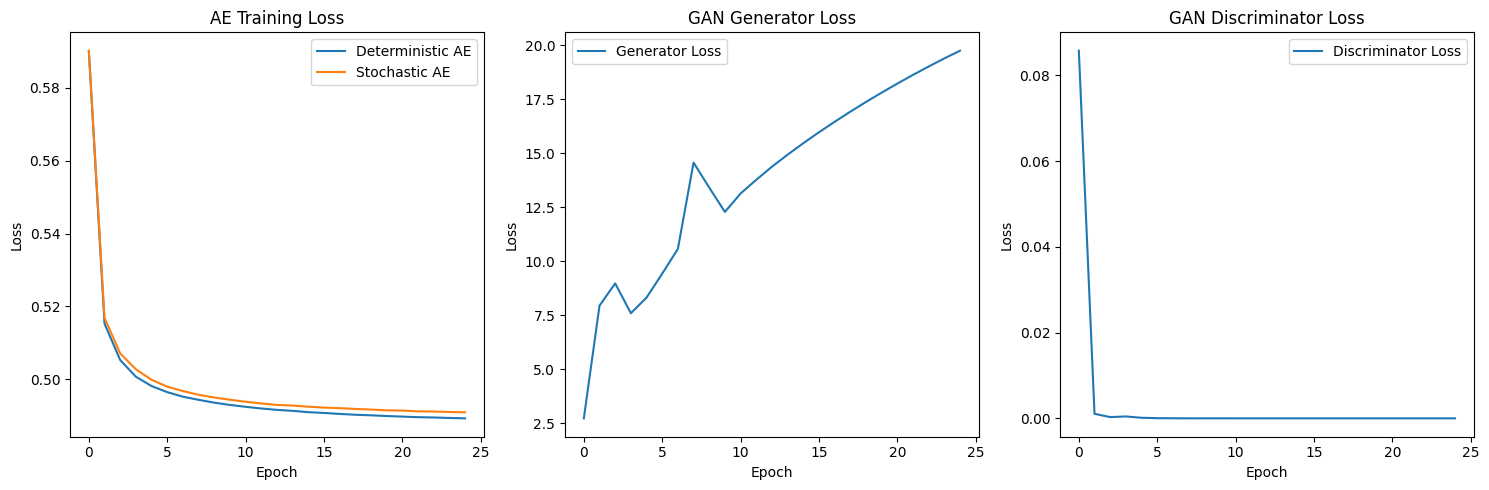

Deterministic AE Val MSE: 0.48802134647369383
Deterministic AE Test MSE: 0.461141060590744
Stochastic AE Val MSE: 0.48978497200012205
Stochastic AE Test MSE: 0.4624700642108917


/tmp/ipython-input-3909632862.py:8: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean = sqrtm(sigma1.dot(sigma2))


Deterministic AE FID: 349.18196292457617
Stochastic AE FID: 350.1860604815309
GAN FID: 733.8385448927606
Deterministic AE IS: 1.7767 ± 0.3482
Stochastic AE IS: 1.6120 ± 0.2827
GAN IS: 1.5381 ± 1.1815
Deterministic AE Clustering:
  Silhouette: 0.0334
  ARI: -0.0000
  NMI: 0.0034
Stochastic AE Clustering:
  Silhouette: 0.0411
  ARI: -0.0003
  NMI: 0.0030


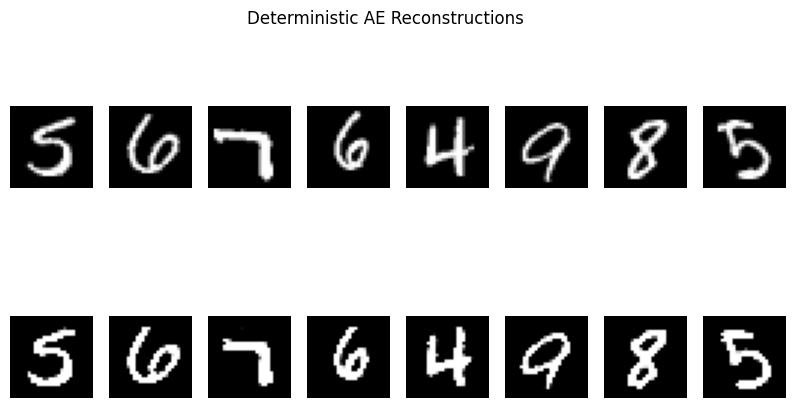

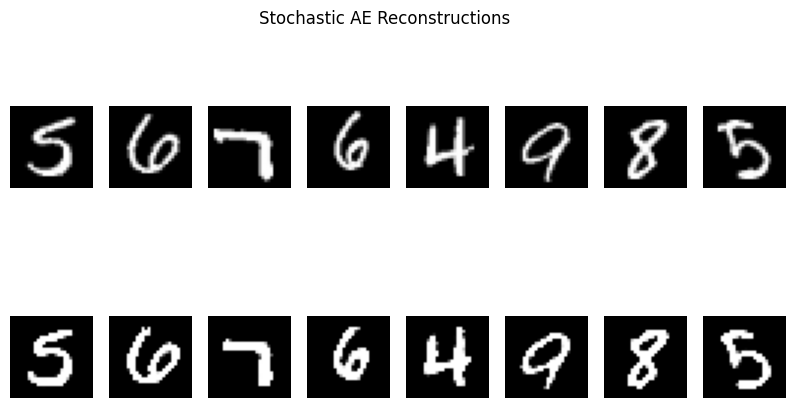

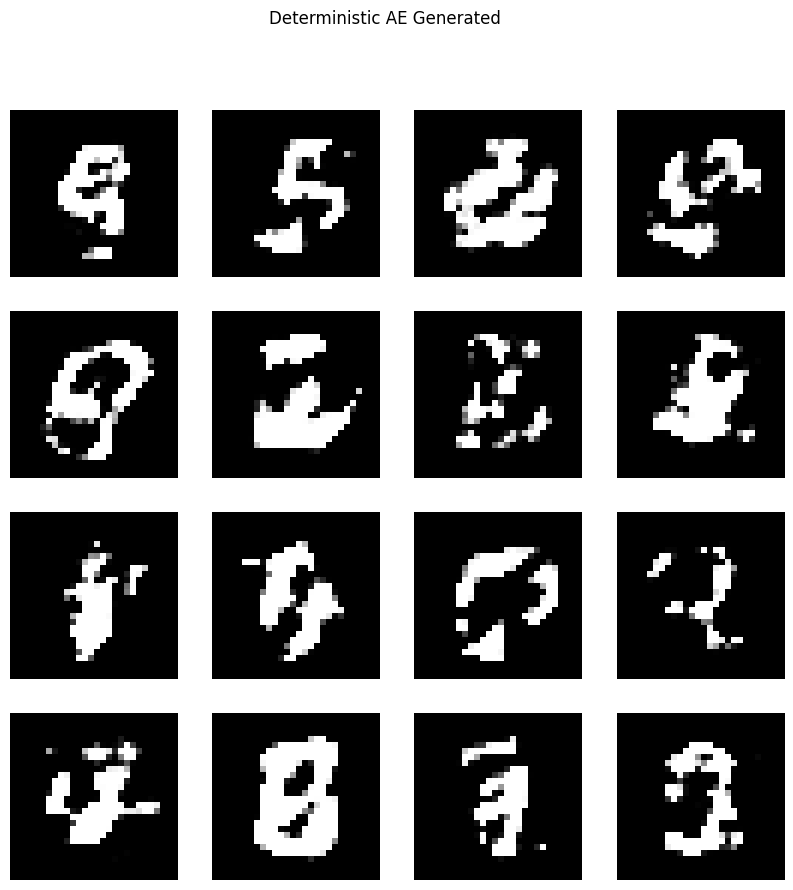

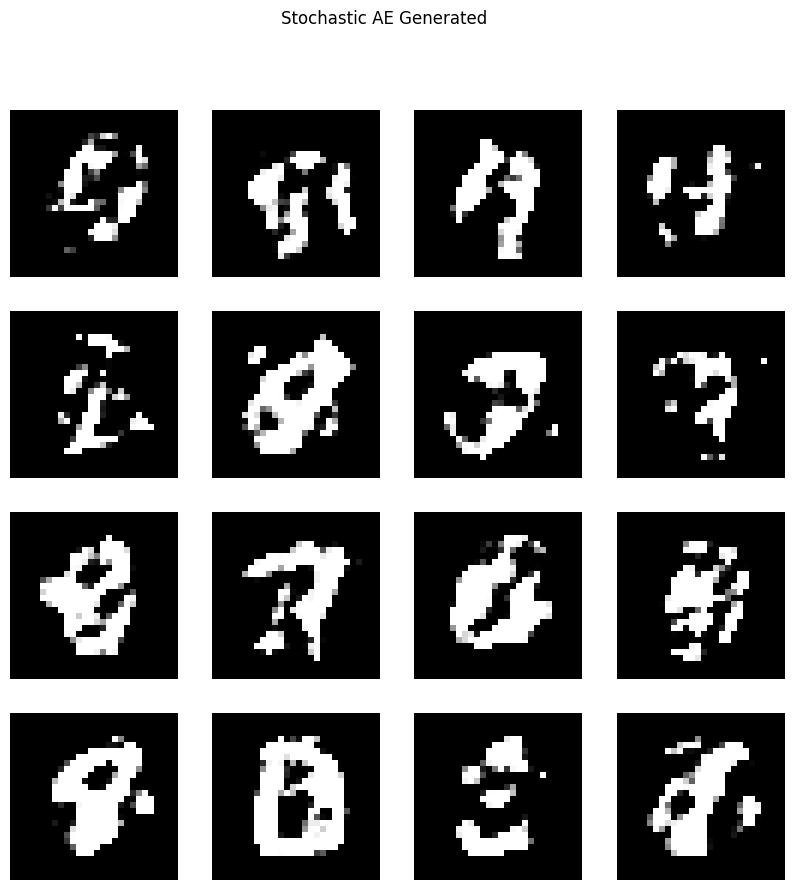

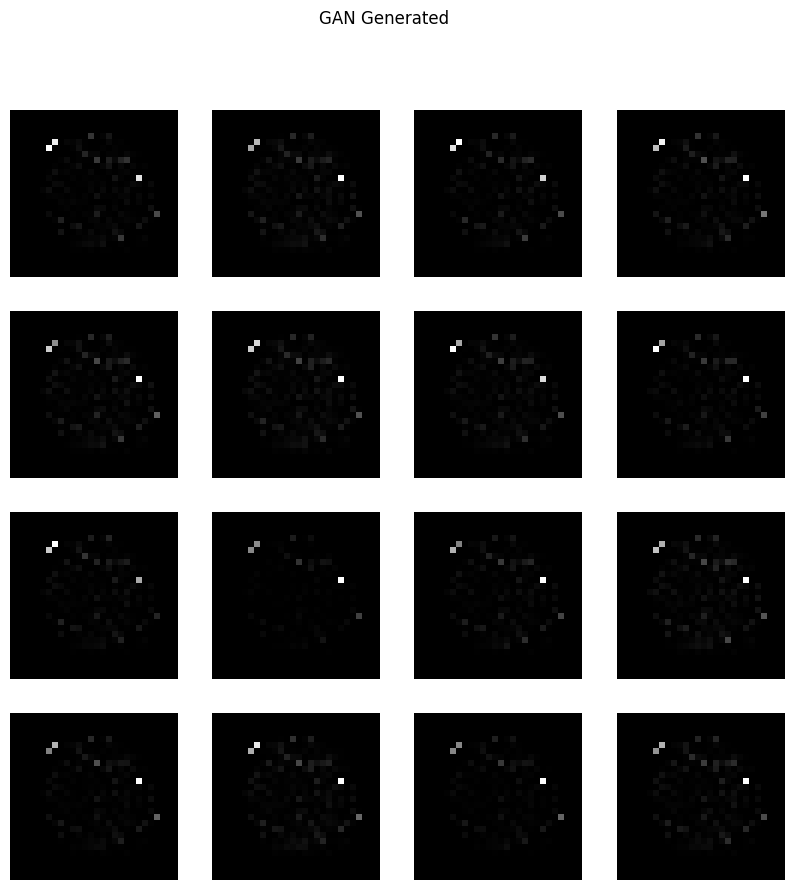

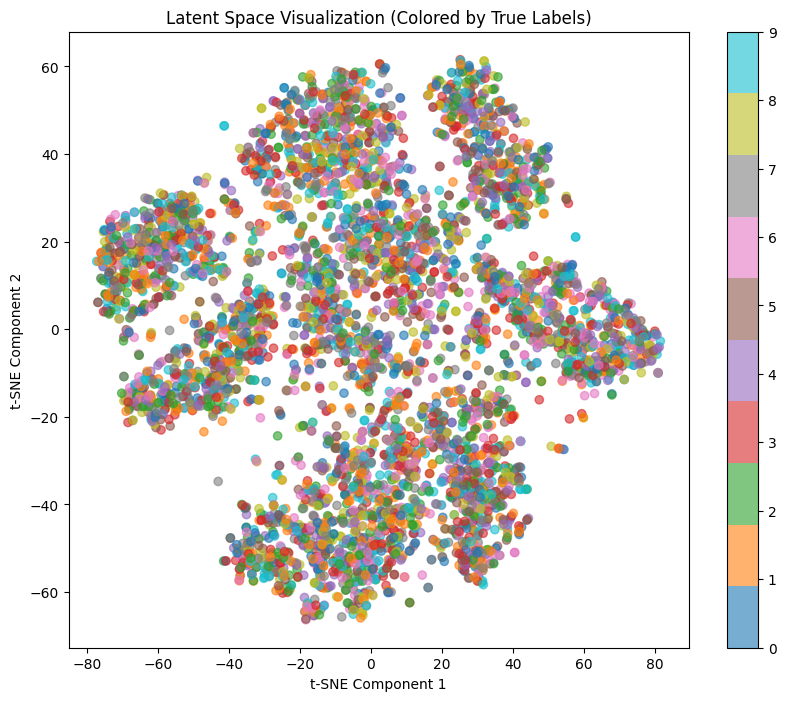

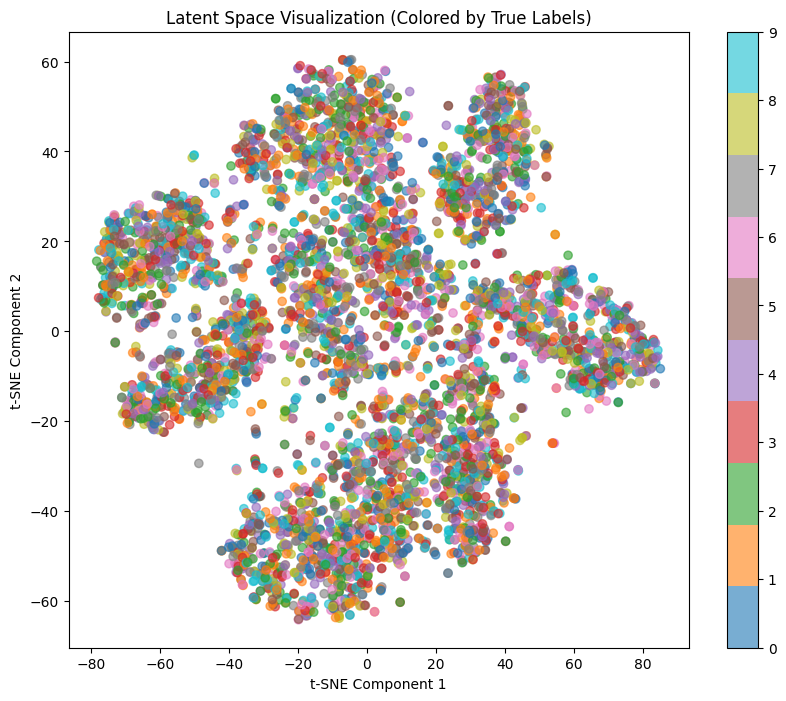

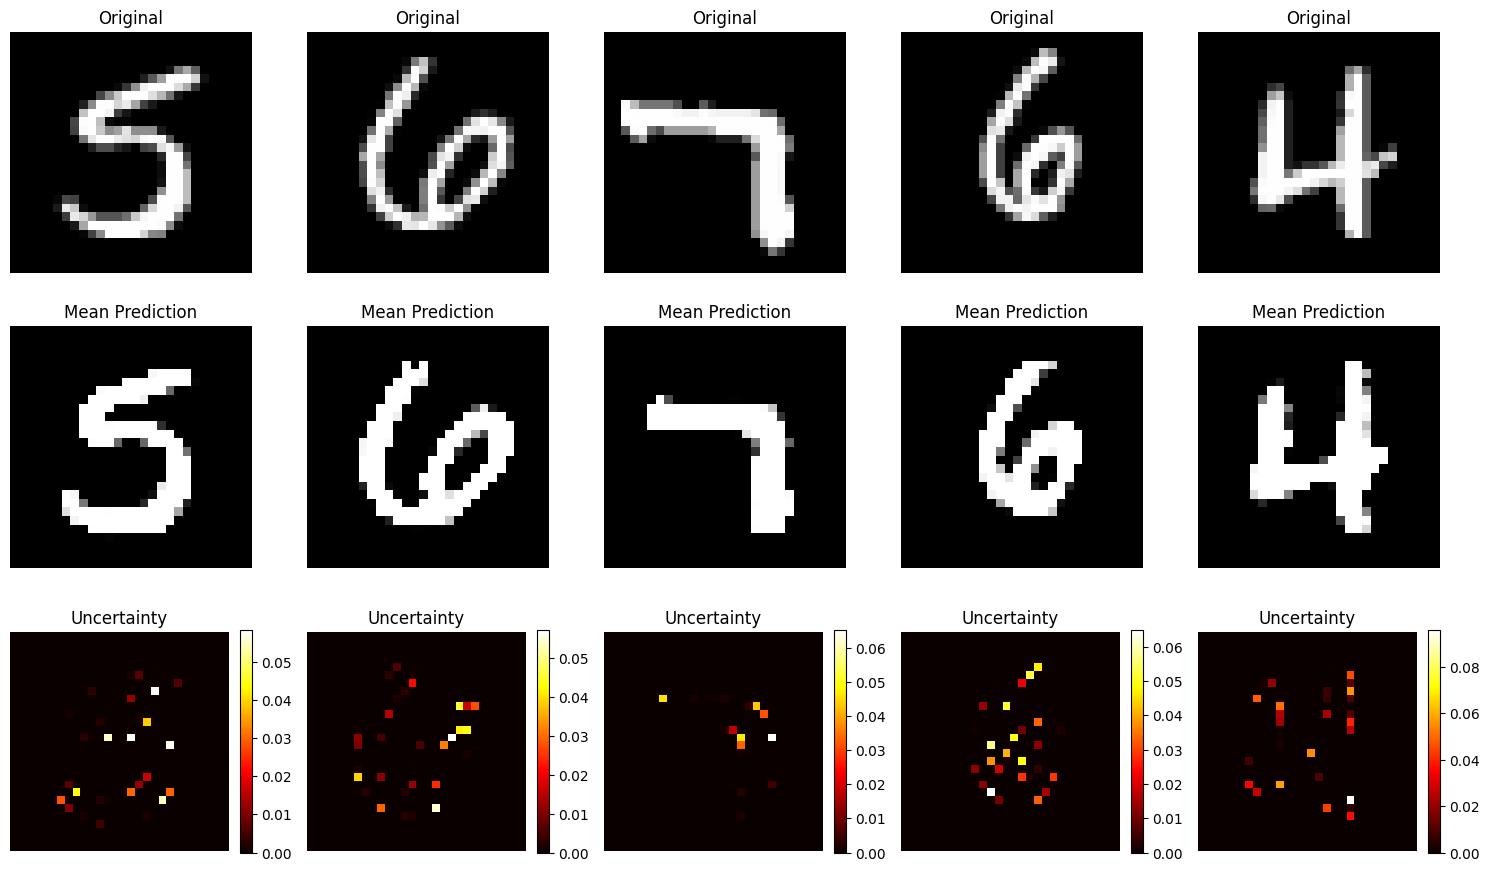


Analyzing model stability...
Stability run 1/3
Deterministic AE Epoch 0: Loss = 0.5900
Deterministic AE Epoch 10: Loss = 0.4939
Stochastic AE Epoch 0: Loss = 0.5888
Stochastic AE Epoch 10: Loss = 0.4937
GAN Epoch 0: G Loss = 2.7135, D Loss = 0.0891
GAN Epoch 10: G Loss = 13.5086, D Loss = 0.0000


/tmp/ipython-input-3909632862.py:8: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean = sqrtm(sigma1.dot(sigma2))


Stability run 2/3
Deterministic AE Epoch 0: Loss = 0.5909
Deterministic AE Epoch 10: Loss = 0.4957
Stochastic AE Epoch 0: Loss = 0.5863
Stochastic AE Epoch 10: Loss = 0.4942
GAN Epoch 0: G Loss = 2.9488, D Loss = 0.0753
GAN Epoch 10: G Loss = 12.9723, D Loss = 0.0000
Stability run 3/3
Deterministic AE Epoch 0: Loss = 0.5921
Deterministic AE Epoch 10: Loss = 0.4956
Stochastic AE Epoch 0: Loss = 0.5935
Stochastic AE Epoch 10: Loss = 0.4932
GAN Epoch 0: G Loss = 2.6832, D Loss = 0.0900
GAN Epoch 10: G Loss = 13.7990, D Loss = 0.0000

Stability Analysis:
Deterministic AE MSE: 0.4634 ± 0.0010
Stochastic AE MSE: 0.4631 ± 0.0003
GAN FID: 733.6133 ± 3.8225


In [ ]:
print("Non-Deterministic Unsupervised Neural Network - GAN Implementation")
print("=" * 70)

print("Training Deterministic AE...")
encoder_det, decoder_det, losses_det = train_ae(stochastic=False)

print("Training Stochastic AE...")
encoder_stoch, decoder_stoch, losses_stoch = train_ae(stochastic=True)

print("Training GAN...")
generator, losses_g, losses_d = train_gan()

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(losses_det, label='Deterministic AE')
plt.plot(losses_stoch, label='Stochastic AE')
plt.title('AE Training Loss'); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()
plt.subplot(1, 3, 2)
plt.plot(losses_g, label='Generator Loss')
plt.title('GAN Generator Loss'); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()
plt.subplot(1, 3, 3)
plt.plot(losses_d, label='Discriminator Loss')
plt.title('GAN Discriminator Loss'); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()
plt.tight_layout()
plt.show()

gen_det = generate_ae_samples(encoder_det, decoder_det, stochastic=False)
gen_stoch = generate_ae_samples(encoder_stoch, decoder_stoch, stochastic=True)
gen_gan = generate_gan_samples(generator)

real_list = []
label_list = []
for real, labels in test_loader:
    real_list.append(flatten_batch(real).cpu().numpy())
    label_list.extend(labels.numpy())
real_samples = np.concatenate(real_list, axis=0)
test_labels = np.array(label_list)
mse_det_val = compute_mse(encoder_det, decoder_det, val_loader)
mse_det_test = compute_mse(encoder_det, decoder_det, test_loader)
mse_stoch_val = compute_mse(encoder_stoch, decoder_stoch, val_loader)
mse_stoch_test = compute_mse(encoder_stoch, decoder_stoch, test_loader)

print("Deterministic AE Val MSE:", mse_det_val)
print("Deterministic AE Test MSE:", mse_det_test)
print("Stochastic AE Val MSE:", mse_stoch_val)
print("Stochastic AE Test MSE:", mse_stoch_test)
fid_det = calculate_fid_simplified(real_samples, gen_det)
fid_stoch = calculate_fid_simplified(real_samples, gen_stoch)
fid_gan = calculate_fid_simplified(real_samples, gen_gan)

is_det_mean, is_det_std = calculate_inception_score(gen_det)
is_stoch_mean, is_stoch_std = calculate_inception_score(gen_stoch)
is_gan_mean, is_gan_std = calculate_inception_score(gen_gan)

print("Deterministic AE FID:", fid_det)
print("Stochastic AE FID:", fid_stoch)
print("GAN FID:", fid_gan)

print("Deterministic AE IS:", f"{is_det_mean:.4f} ± {is_det_std:.4f}")
print("Stochastic AE IS:", f"{is_stoch_mean:.4f} ± {is_stoch_std:.4f}")
print("GAN IS:", f"{is_gan_mean:.4f} ± {is_gan_std:.4f}")
latent_det_list = []
latent_stoch_list = []
with torch.no_grad():
    for real, _ in test_loader:
        real = flatten_batch(real).to(device)
        latent_det_list.append(encoder_det(real))
        mu_stoch = encoder_stoch(real)
        epsilon = torch.randn_like(mu_stoch).to(device) * 0.1
        latent_stoch_list.append(mu_stoch + epsilon)
latent_det = torch.cat(latent_det_list, dim=0).cpu().numpy()
latent_stoch = torch.cat(latent_stoch_list, dim=0).cpu().numpy()
clustering_det = evaluate_clustering_quality(latent_det, test_labels)
clustering_stoch = evaluate_clustering_quality(latent_stoch, test_labels)

print("Deterministic AE Clustering:")
print(f"  Silhouette: {clustering_det['silhouette_score']:.4f}")
print(f"  ARI: {clustering_det['adjusted_rand_index']:.4f}")
print(f"  NMI: {clustering_det['normalized_mutual_info']:.4f}")

print("Stochastic AE Clustering:")
print(f"  Silhouette: {clustering_stoch['silhouette_score']:.4f}")
print(f"  ARI: {clustering_stoch['adjusted_rand_index']:.4f}")
print(f"  NMI: {clustering_stoch['normalized_mutual_info']:.4f}")
test_data, _ = next(iter(test_loader))
visualize_reconstructions(encoder_det, decoder_det, test_data, "Deterministic AE Reconstructions", "det_recon.png", stochastic=False)
visualize_reconstructions(encoder_stoch, decoder_stoch, test_data, "Stochastic AE Reconstructions", "stoch_recon.png", stochastic=True)
visualize_generated_samples(gen_det, "Deterministic AE Generated", "det_gen.png")
visualize_generated_samples(gen_stoch, "Stochastic AE Generated", "stoch_gen.png")
visualize_generated_samples(gen_gan, "GAN Generated", "gan_gen.png")

visualize_latent_space(latent_det, test_labels)
visualize_latent_space(latent_stoch, test_labels)

uncertainty_analysis(encoder_stoch, decoder_stoch, test_data)

print("\nAnalyzing model stability...")
stability_mse_det = []
stability_mse_stoch = []
stability_fid_gan = []
for run in range(3):
    print(f"Stability run {run + 1}/3")

    enc_det_temp, dec_det_temp, _ = train_ae(stochastic=False, epochs=20)
    mse_temp = compute_mse(enc_det_temp, dec_det_temp, test_loader)
    stability_mse_det.append(mse_temp)

    enc_stoch_temp, dec_stoch_temp, _ = train_ae(stochastic=True, epochs=20)
    mse_temp = compute_mse(enc_stoch_temp, dec_stoch_temp, test_loader)
    stability_mse_stoch.append(mse_temp)

    gen_temp, _, _ = train_gan(epochs=20)
    gen_samples_temp = generate_gan_samples(gen_temp)
    fid_temp = calculate_fid_simplified(real_samples[:len(gen_samples_temp)], gen_samples_temp)
    stability_fid_gan.append(fid_temp)

print("\nStability Analysis:")
print(f"Deterministic AE MSE: {np.mean(stability_mse_det):.4f} ± {np.std(stability_mse_det):.4f}")
print(f"Stochastic AE MSE: {np.mean(stability_mse_stoch):.4f} ± {np.std(stability_mse_stoch):.4f}")
print(f"GAN FID: {np.mean(stability_fid_gan):.4f} ± {np.std(stability_fid_gan):.4f}")